In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint
import aesara.tensor as at

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg").loc[::10]

xy = pd.DataFrame({"x": data.geometry.x, "y": data.geometry.y})
d = distance_matrix(xy, xy) / 1000
O_norm = (
    StandardScaler()
    .fit_transform(data.orthodox_proportion_ln.values.reshape(-1, 1))
    .flatten()
)
data["group"] = data.district.factorize()[0]

N = data.shape[0]
SEED = 42
N_CLUSTERS = len(data.group.unique())

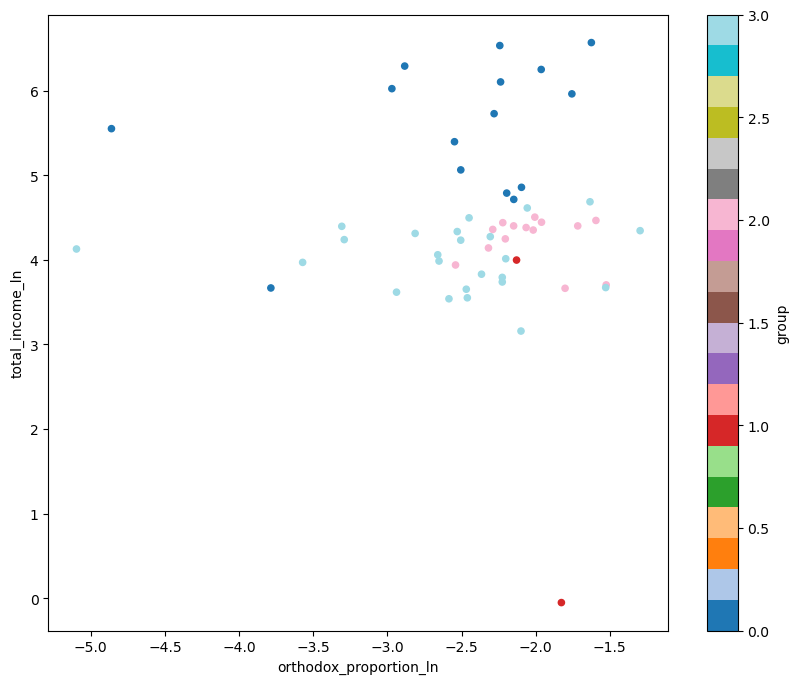

In [2]:
cluster_colors = plt.get_cmap("tab20")
data.plot(
    kind="scatter",
    x="orthodox_proportion_ln",
    y="total_income_ln",
    c="group",
    cmap="tab20",
    figsize=(10, 8),
)
plt.show()

In [3]:
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [4]:
data.explore(
    column="total_income_ln",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)


In [5]:
data.explore(
    column="lutheran",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [6]:
data.explore(
    column="orthodox_proportion",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

# Model 1

A simpler model without spatial regression

$$ O_i \sim Beta(\mu_i, \sigma) $$
$$ \sigma \sim HalfNormal(0.01) $$
$$ \mu_i = \frac{1}{1 - exp(\beta_{k[i],0} + \beta_{k[i],1} W)} $$
$$ \beta \sim MvNormal \left( \theta, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ \theta \sim Normal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 \\ 0.1 \end{bmatrix} \right) $$

In [7]:
# with pm.Model() as model_1:
#     idx = data.group
#     W = pm.MutableData("W", data.total_income_ln)

#     θ = pm.Normal("θ", [0, 0], [0.1, 0.1], shape=2)

#     β = pm.MvNormal(
#         "β", mu=θ, cov=np.diagflat(np.array([0.1, 0.1])), shape=(N_CLUSTERS, 2)
#     )
#     μ = at.exp(β[idx, 0] + β[idx, 1] * W)
#     σ = pm.HalfNormal("σ", 0.01)

#     O = pm.Beta("O", mu=μ, sigma=σ, observed=data.orthodox_proportion)

#     prior_1 = pm.sample_prior_predictive()
#     posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True, target_accept=0.95)
#     posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

In [8]:
# graph_1 = pm.model_to_graphviz(model_1)
# graph_1

In [9]:
# az.plot_posterior(posterior_1, grid=(N_CLUSTERS + 2, 2))
# plt.show()

In [10]:
# az.plot_trace(posterior_1)
# plt.show()

In [11]:
# az.plot_forest(posterior_1, combined=True, hdi_prob=0.94)
# plt.show()

In [12]:
# az.plot_ppc(posterior_prediction_1)
# plt.show()

# Model 2

Heavier spatial error model

$$ O_i \sim Normal(\mu_i, \sigma) $$
$$ \sigma \sim Exponential(10) $$
$$ \mu_i = \beta_{k[i],0} + \beta_{k[i],1} W + \gamma_i $$
$$ \beta_k \sim MvNormal \left( \theta, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ \theta \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ \gamma \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}_{(i)}, \bold K \right) $$
$$ \bold K = \eta^2 exp \left( -\rho^2 D^2 \right) + \bold I_{(i)} * 0.01 $$
$$ \eta^2, \rho^2 \sim HalfCauchy(1) $$

In [13]:
with pm.Model() as model_2:
    idx = data.group
    W = pm.MutableData("W", data.total_income_ln)

    θ = pm.Normal("θ", [0, 0], [0.1, 0.1], shape=2)
    β = pm.MvNormal(
        "β", mu=θ, cov=np.diagflat(np.array([0.01, 0.01])), shape=(N_CLUSTERS, 2)
    )

    η2 = pm.HalfCauchy("η²", 1)
    ρ2 = pm.HalfCauchy("ρ²", 1)
    K = η2 * at.exp(-ρ2 * at.power(d, 2)) + np.diag([0.01] * N)

    γ = pm.MvNormal("γ", mu=np.zeros(N), cov=K, shape=N)
    μ = β[idx, 0] + β[idx, 1] * W + γ
    σ = pm.Exponential("σ", 10)
    O = pm.Normal("O", mu=μ, sigma=σ, observed=O_norm)

    prior_2 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_2 = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.95,
        random_seed=SEED,
    )
    posterior_prediction_2 = pm.sample_posterior_predictive(
        posterior_2,
        random_seed=SEED,
    )

Sampling: [O, β, γ, η², θ, ρ², σ]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, β, η², ρ², γ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4041 seconds.
Sampling: [O]


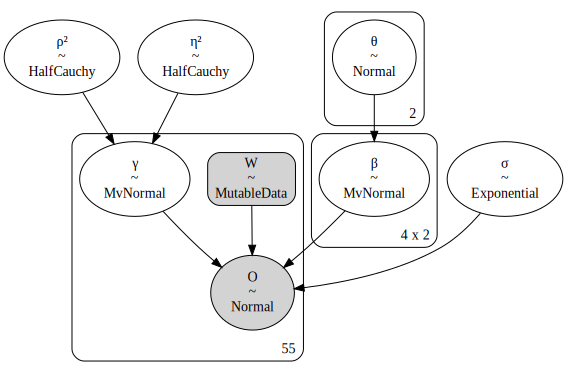

In [14]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

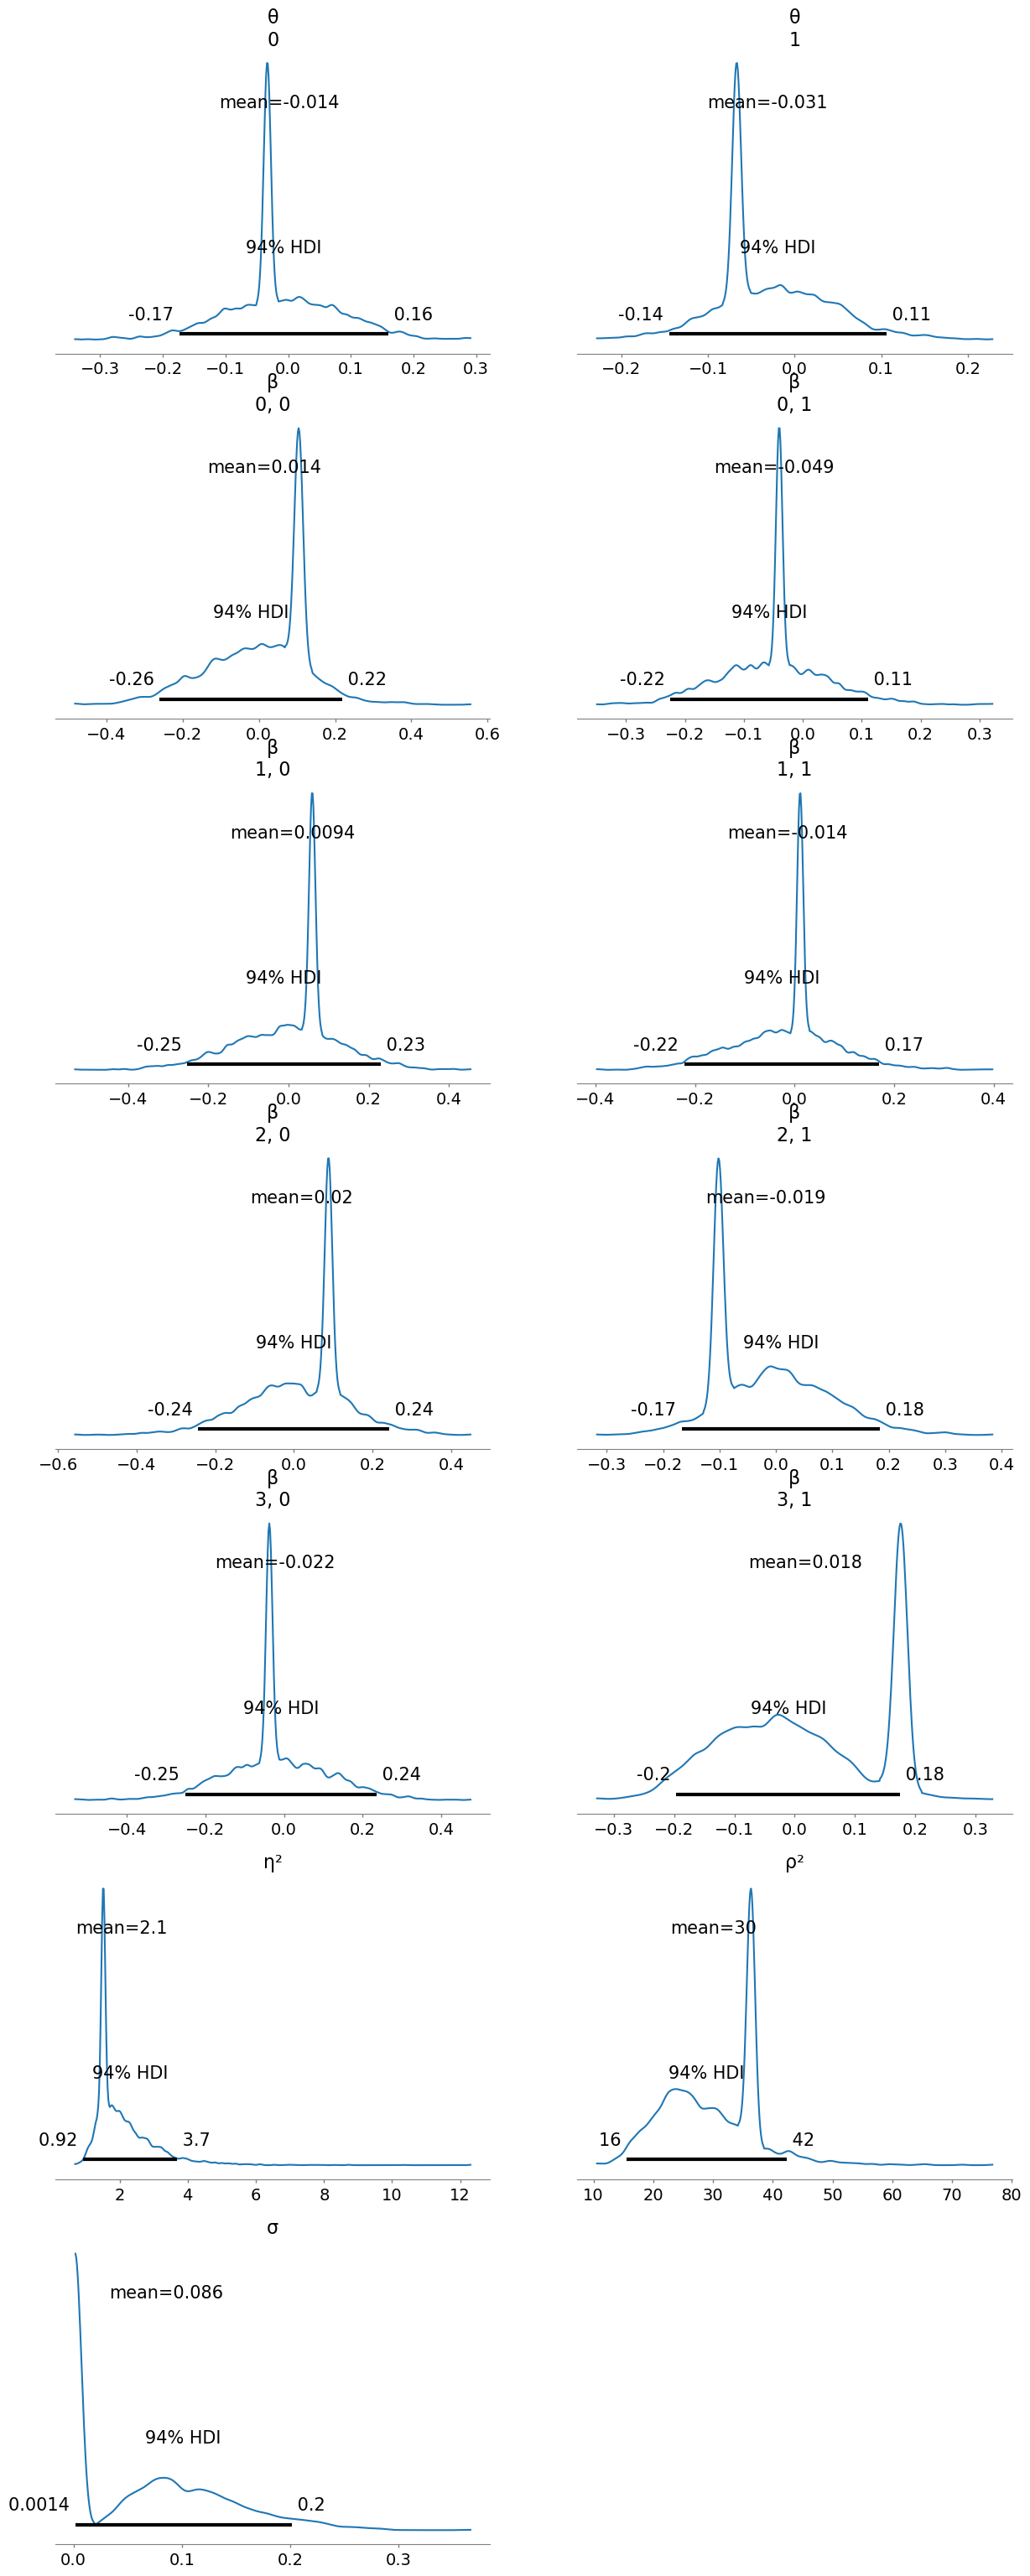

In [15]:
az.plot_posterior(posterior_2, grid=(N_CLUSTERS + 3, 2), var_names="~γ")
plt.show()

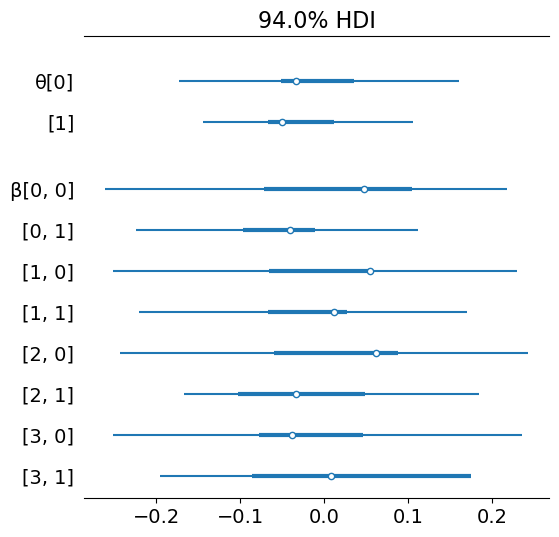

In [16]:
az.plot_forest(posterior_2, combined=True, hdi_prob=0.94, var_names=["θ", "β"])
plt.show()

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  wa

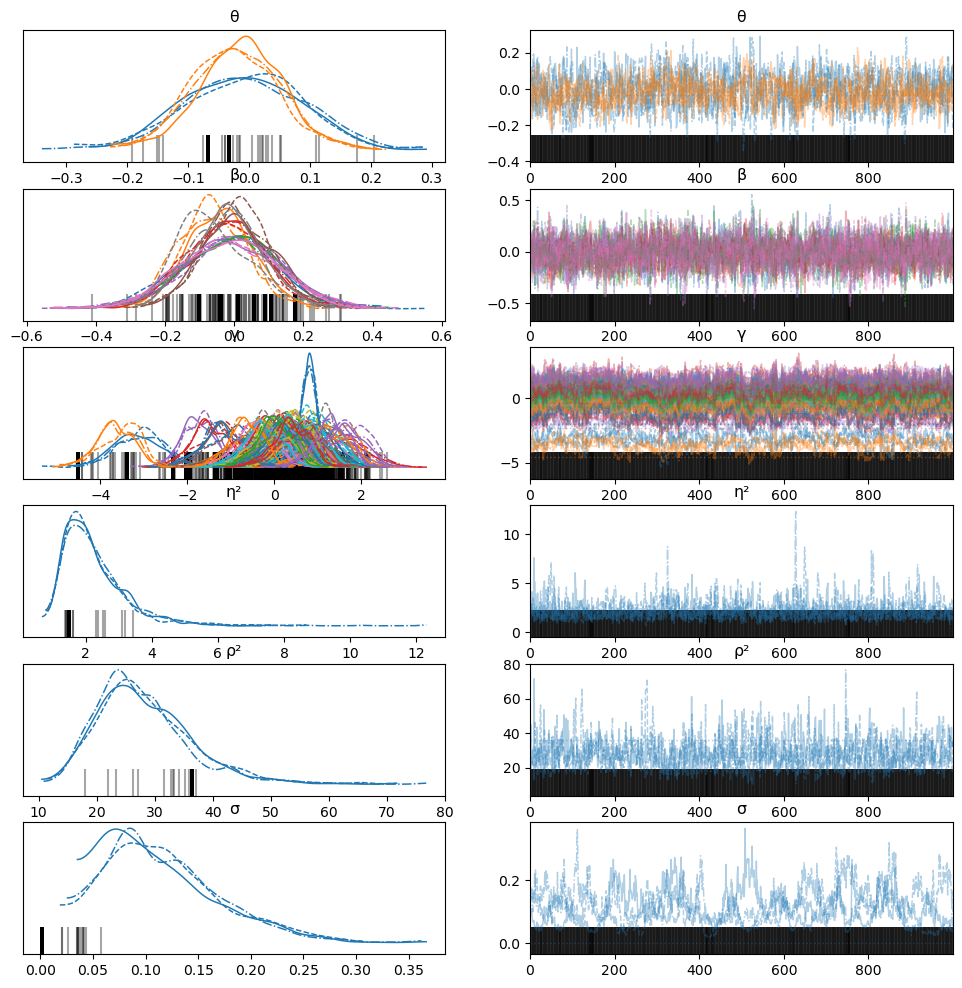

In [17]:
az.plot_trace(posterior_2)
plt.show()

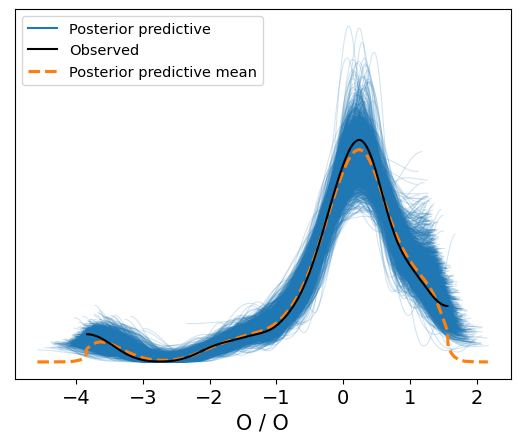

In [18]:
az.plot_ppc(posterior_prediction_2)
plt.show()